In [1]:
import sys
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
import nibabel as nib
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 24
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'AttUnet_02' #save version 
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/'

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

----

# Model

In [3]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply

def AttUnet_model(input_layer, attention_mode='grid'):
    #downsampling path
    conv1 = conv_block(input_layer, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn, dropout_rate = dropout)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn, dropout_rate = dropout)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    #injection block 1
    seg01 = Conv2D(4,(1,1),padding='same')(conv7)
    up_seg01 = UpSampling2D()(seg01)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    #injection block 2
    seg02 = Conv2D(4,(1,1),padding='same')(conv8)
    add_21 = Add()([seg02, up_seg01])
    up_seg02 = UpSampling2D()(add_21)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    #injection block 3
    seg03 = Conv2D(4,(1,1),padding='same')(conv9)
    add_32 = Add()([seg03, up_seg02])
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(add_32)
    
    return output_layer

In [4]:
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image)
        loss = custom_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients


Epochs  1



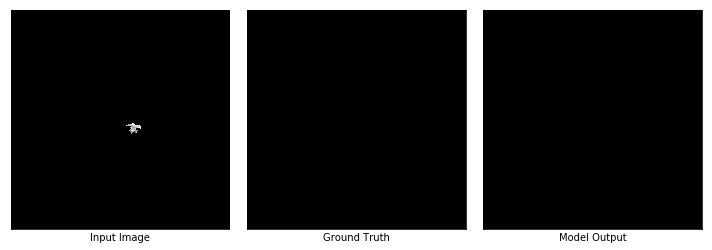

Steps: 2000, Loss:0.25610750913619995
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.12141013145446777, max:0.11895900219678879

Epochs  2



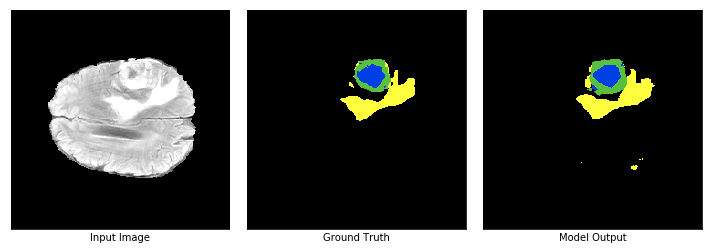

Steps: 2000, Loss:0.1750974953174591
Accurary: 0.9902083277702332
Dice coefficient: [0.91913533, 0.84560907, 0.9175541]
Sensitivity: [0.9965277778079186, 0.9644588050975961, 0.9816244028606232]
Specificity: [0.9964923469393969, 0.9965602569283515, 0.9921645802598144]
Gradient min:-0.11025046557188034, max:0.18533465266227722

Epochs  3



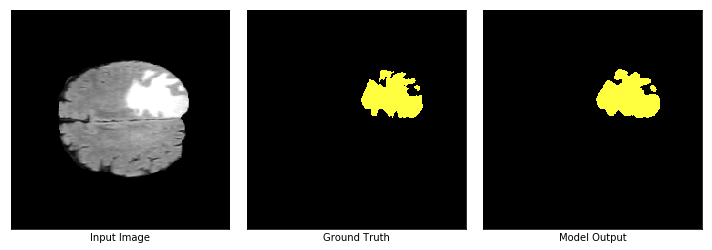

Steps: 2000, Loss:0.25295189023017883
Accurary: 0.995555579662323
Dice coefficient: [0.0, 0.0, 0.94717294]
Sensitivity: [1.0, 1.0, 0.9736953755889038]
Specificity: [1.0, 1.0, 0.996488242854934]
Gradient min:-0.07416949421167374, max:0.1557859480381012

Epochs  4



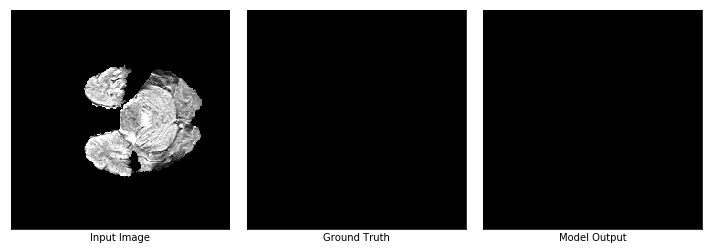

Steps: 2000, Loss:0.1782236099243164
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.037139248102903366, max:0.04157133400440216

Epochs  5



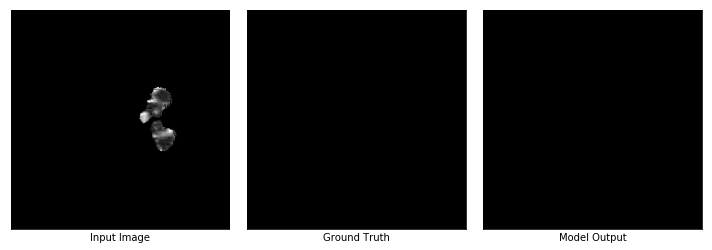

Steps: 2000, Loss:0.4799785614013672
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.4913285970687866, max:0.784788191318512

-----------<Summary for Epoch:5>------------
Mean Accuracy: 0.9952098727226257
Mean Dice coefficient: [0.2450962 0.2037313 0.352881 ]
Mean Sensitivity: [0.91862975 0.93076059 0.86832111]
Mean Specificity: [0.99947428 0.99959047 0.99902379]
------------------------------------------------


Epochs  6



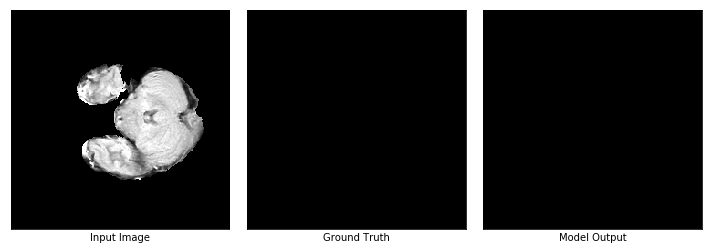

Steps: 2000, Loss:0.7542115449905396
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.09082378447055817, max:0.12142676115036011

Epochs  7



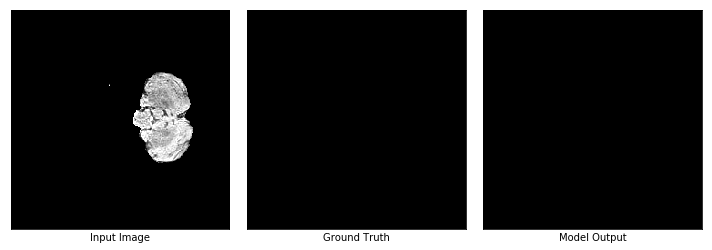

Steps: 2000, Loss:0.1737222969532013
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02401570975780487, max:0.022607451304793358

Epochs  8



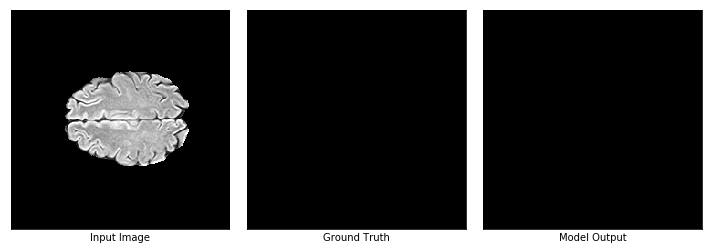

Steps: 2000, Loss:0.1299394816160202
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03717825561761856, max:0.029949981719255447

Epochs  9



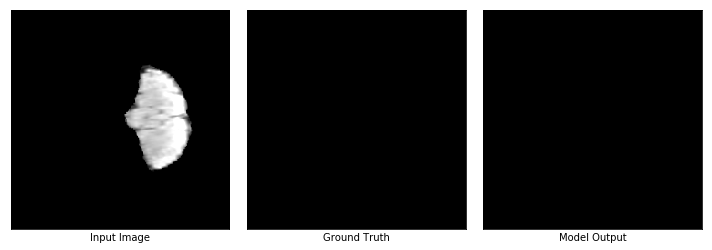

Steps: 2000, Loss:0.18365728855133057
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06584141403436661, max:0.07192257046699524

Epochs 10



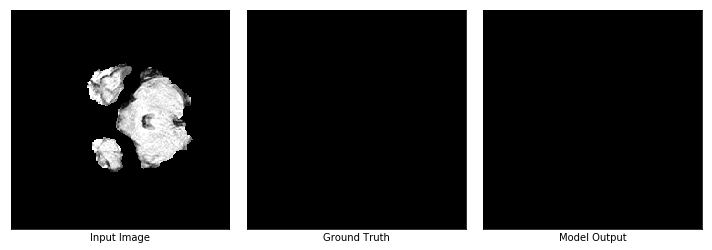

Steps: 2000, Loss:0.11370709538459778
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02143111824989319, max:0.0163576640188694

-----------<Summary for Epoch:10>------------
Mean Accuracy: 0.9959367513656616
Mean Dice coefficient: [0.25784049 0.21655788 0.36760864]
Mean Sensitivity: [0.92928928 0.94039007 0.88420262]
Mean Specificity: [0.99958639 0.99968406 0.99917027]
------------------------------------------------


Epochs 11



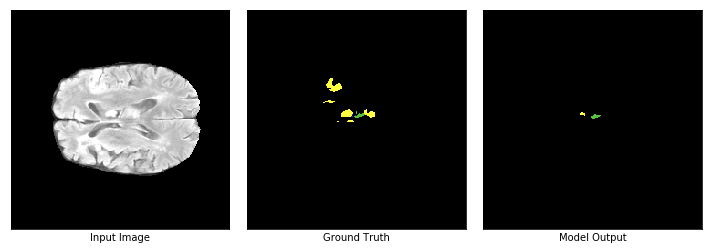

Steps: 2000, Loss:0.11823908984661102
Accurary: 0.9943923354148865
Dice coefficient: [0.6111112, 0.63636374, 0.19095479]
Sensitivity: [0.5365854788815905, 0.6000001142856816, 0.1082621336677455]
Specificity: [0.999843638701186, 0.9998262833319159, 0.9998427920138617]
Gradient min:-0.046544451266527176, max:0.07308529317378998

Epochs 12



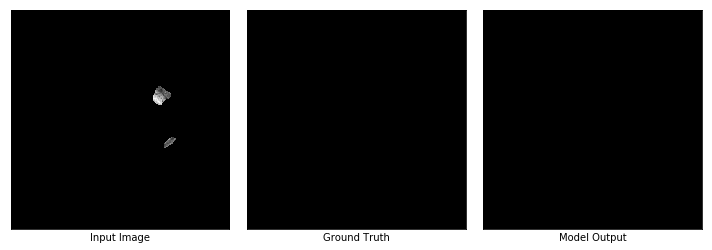

Steps: 2000, Loss:0.18663445115089417
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05193566903471947, max:0.0700143426656723

Epochs 13



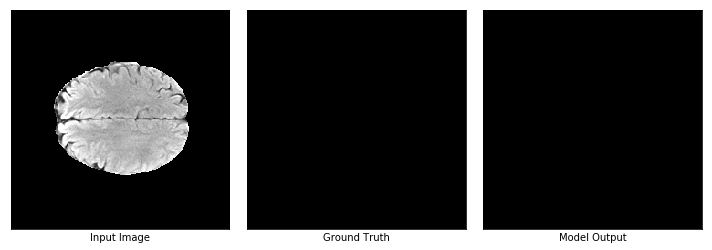

Steps: 2000, Loss:0.12987157702445984
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.057242751121520996, max:0.049680668860673904

Epochs 14



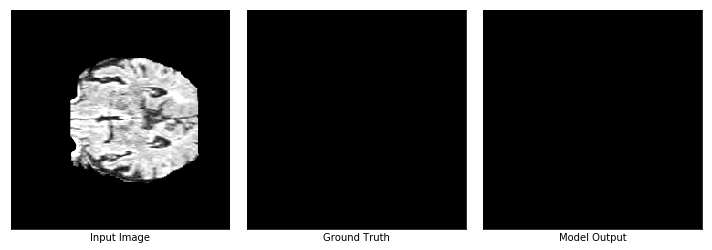

Steps: 2000, Loss:0.10532476752996445
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02581394650042057, max:0.018616247922182083

Epochs 15



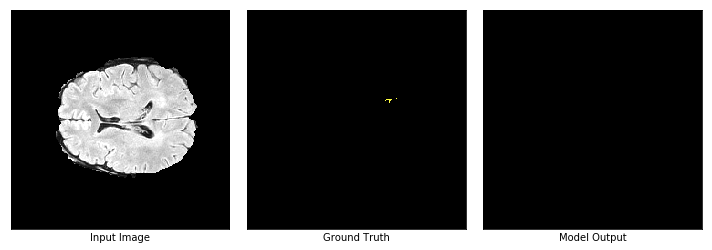

Steps: 2000, Loss:0.18294471502304077
Accurary: 0.9997222423553467
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 6.249996093752442e-07]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05778041109442711, max:0.06040959805250168

-----------<Summary for Epoch:15>------------
Mean Accuracy: 0.9963518977165222
Mean Dice coefficient: [0.26656574 0.22390679 0.37998836]
Mean Sensitivity: [0.93719289 0.94597182 0.89655905]
Mean Specificity: [0.99964    0.99973441 0.99925737]
------------------------------------------------


Epochs 16



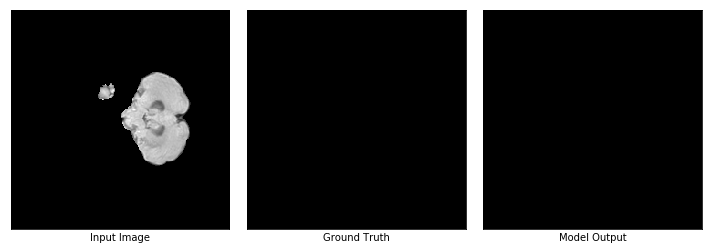

Steps: 2000, Loss:0.09156649559736252
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03021649643778801, max:0.0391402393579483

Epochs 17



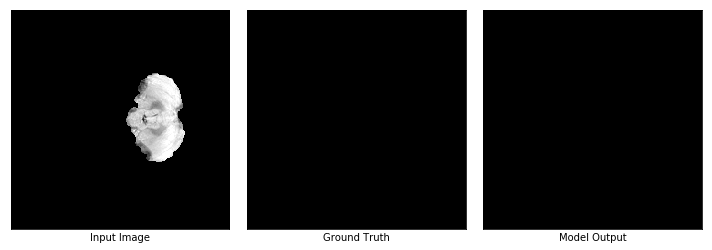

Steps: 2000, Loss:0.18747413158416748
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.19183756411075592, max:0.23287484049797058

Epochs 18



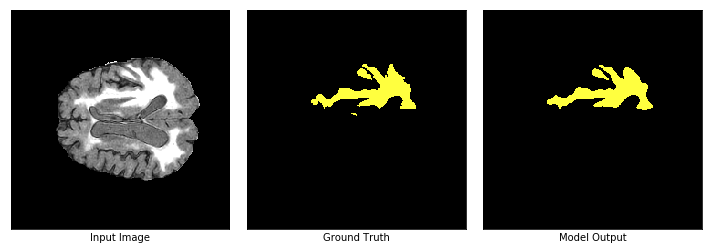

Steps: 2000, Loss:0.12256624549627304
Accurary: 0.9944791793823242
Dice coefficient: [0.0, 0.0, 0.92853934]
Sensitivity: [1.0, 1.0, 0.9306306309431053]
Specificity: [1.0, 1.0, 0.9970386421095994]
Gradient min:-0.06086322292685509, max:0.07589039206504822

Epochs 19



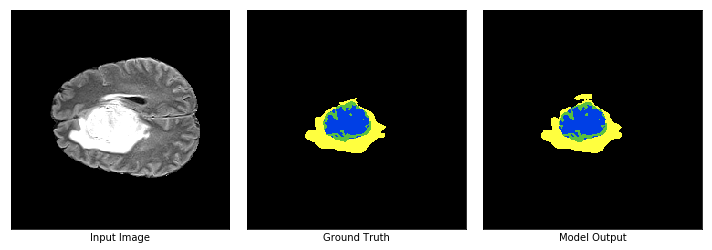

Steps: 2000, Loss:0.10675331205129623
Accurary: 0.9943923354148865
Dice coefficient: [0.9853425, 0.91067964, 0.96779966]
Sensitivity: [0.9921686747459718, 0.9054054072315558, 0.9815542788583179]
Specificity: [0.9993564533429824, 0.9992466977332177, 0.9971451199975788]
Gradient min:-0.019058791920542717, max:0.014570373110473156

Epochs 20



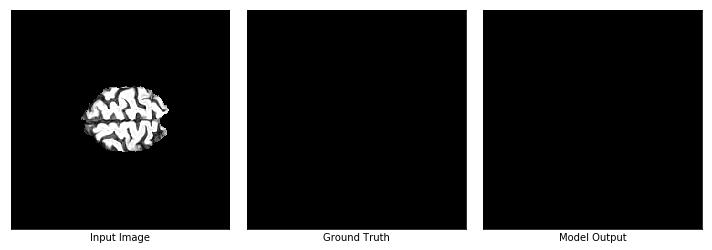

Steps: 2000, Loss:0.14438396692276
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.025701822713017464, max:0.02213759534060955

-----------<Summary for Epoch:20>------------
Mean Accuracy: 0.9966337084770203
Mean Dice coefficient: [0.26814872 0.22543732 0.38321486]
Mean Sensitivity: [0.9395253  0.94719408 0.89962331]
Mean Specificity: [0.99966011 0.99974724 0.99929422]
------------------------------------------------


Epochs 21



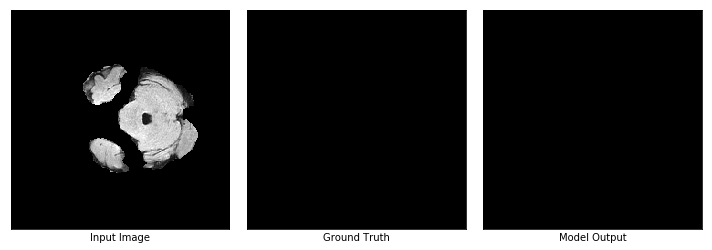

Steps: 2000, Loss:0.5241488218307495
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.34633350372314453, max:0.3562066853046417

Epochs 22



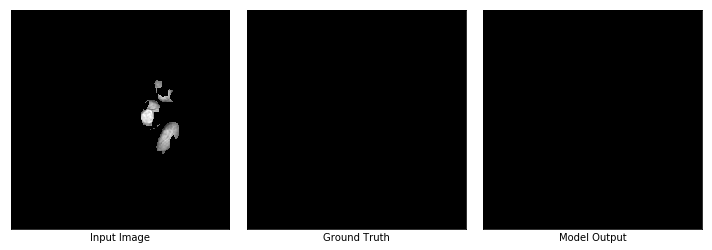

Steps: 2000, Loss:0.09156731516122818
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05581631138920784, max:0.0426708348095417

Epochs 23



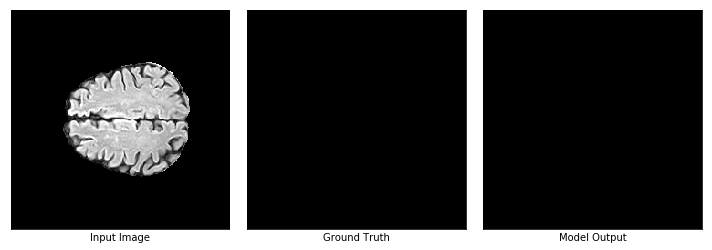

Steps: 2000, Loss:0.10589765757322311
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.01191867608577013, max:0.016300322487950325

Epochs 24



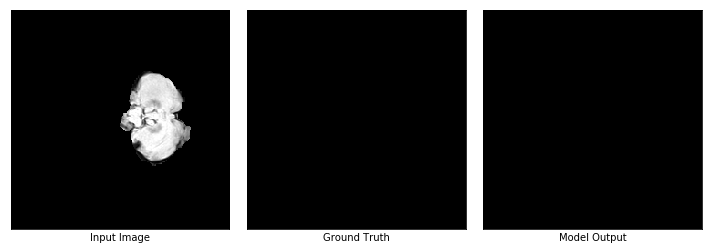

Steps: 2000, Loss:0.11412389576435089
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0844961479306221, max:0.083594411611557

Epochs 25



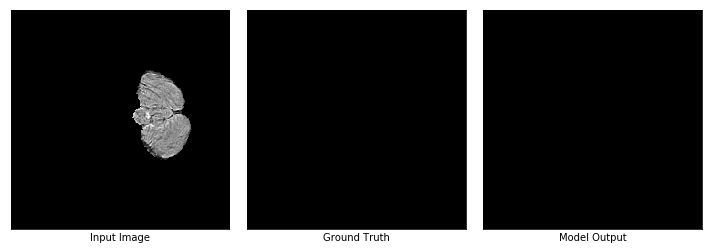

Steps: 2000, Loss:0.18250201642513275
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.021644337102770805, max:0.021750448271632195

-----------<Summary for Epoch:25>------------
Mean Accuracy: 0.9968417882919312
Mean Dice coefficient: [0.27347147 0.23025777 0.39219478]
Mean Sensitivity: [0.94415296 0.95124282 0.90919966]
Mean Specificity: [0.99969994 0.99977121 0.99934026]
------------------------------------------------


Epochs 26



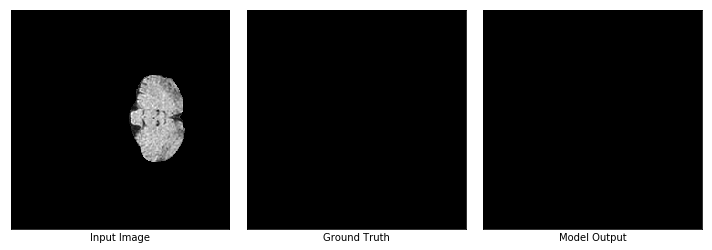

Steps: 2000, Loss:0.09363485872745514
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.019374243915081024, max:0.017548155039548874

Epochs 27



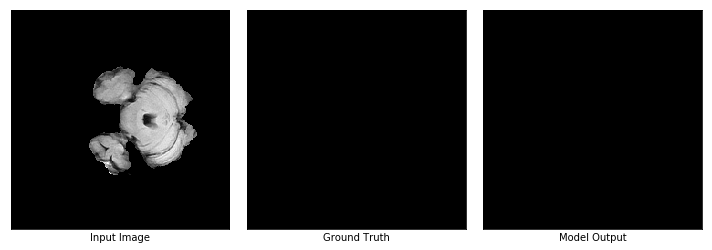

Steps: 2000, Loss:0.10162654519081116
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02459879033267498, max:0.031100798398256302

Epochs 28



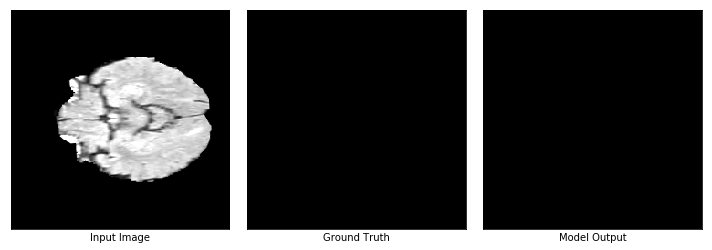

Steps: 2000, Loss:0.11960238963365555
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0133399348706007, max:0.014587162993848324

Epochs 29



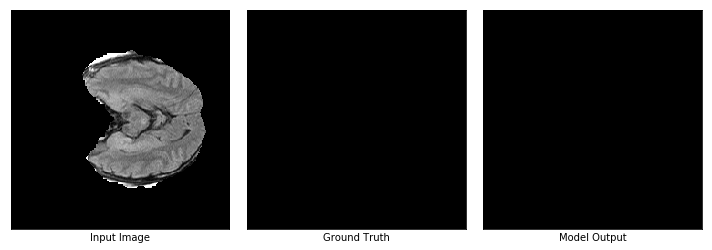

Steps: 2000, Loss:0.09290947020053864
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02805786393582821, max:0.014578425325453281

Epochs 30



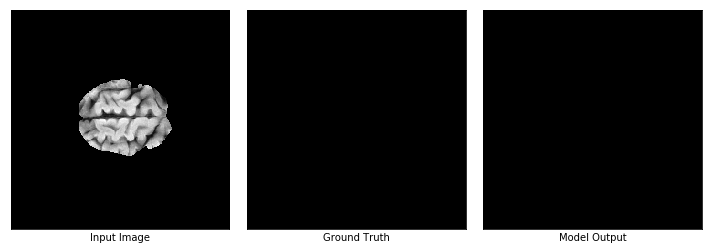

Steps: 2000, Loss:0.10419730097055435
Accurary: 1.0
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02604944258928299, max:0.027050677686929703

-----------<Summary for Epoch:30>------------
Mean Accuracy: 0.9970033764839172
Mean Dice coefficient: [0.27590294 0.23264778 0.39510256]
Mean Sensitivity: [0.94578399 0.9528028  0.91225738]
Mean Specificity: [0.9997325  0.99978754 0.99936683]
------------------------------------------------



In [7]:
epochs = 1
max_epochs = 30
#list
loss_list = []
acc_list = []
loss_inner = []
while epochs <= max_epochs:
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    dc_app = []
    sens_app = []
    spec_app = []
    ds = os.listdir(tfrecords_read_dir)
    #shuffle directory list of tfrecords
    shuffle = random.shuffle(ds)
    for tf_re in ds:
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        acc_inner = []
        for imgs in dataset:
            image = imgs[:,:,:,:4]
            #unprocessed label for plotting 
            label = imgs[:,:,:,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner.append(acc)
            if epochs%5==0:
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
            #output
            if steps%2000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                loss_list.append(loss)
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                print("Steps: {}, Loss:{}".format(steps, loss))
                print("Accurary: {}".format(acc_stp))
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Sensitivity: {}".format(sens_list_stp))
                print("Specificity: {}".format(spec_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        acc_list.append(np.mean(acc_inner))
    if epochs%5==0:
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
    epochs+=1 

---

# Save Weights

In [8]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [5]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def val_fn(image):
    model.trainable = False
    model_output = model(image)
    return model_output

In [6]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
brain_affine = nib.load(actual_label).affine
steps = 1
acc_list = []
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        image = imgs[:,:,:,:4]
        seg_output = 0 #flush RAM
        seg_output = np.zeros((240,240,155))
        for i in range(image.shape[0]):
            inp = tf.expand_dims(image[i],0)
            img_seg = val_fn(inp) #validation function 
            #map from sparse to label
            seg_output[:,:,i] = np.argmax(img_seg,-1) 
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

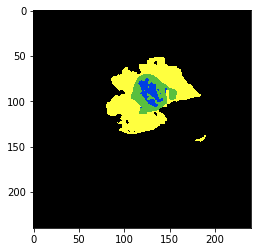

In [11]:
read_path = '/home/kevinteng/Desktop/ssd02/submission/Training_pre/BraTS20_Training_001.nii.gz'
tst_image = nib.load(read_path).get_fdata()
plt.imshow(plot_labels_color(tst_image[:,:,70]), cmap='gray')

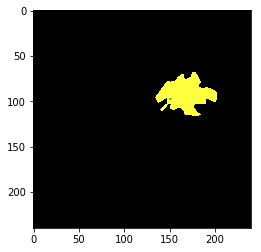

In [18]:
val_path ='/home/kevinteng/Desktop/ssd02/submission/Validation_pre/BraTS20_Validation_001.nii.gz'
val_image = nib.load(val_path).get_fdata()
plt.imshow(plot_labels_color(val_image[:,:,80]), cmap='gray')

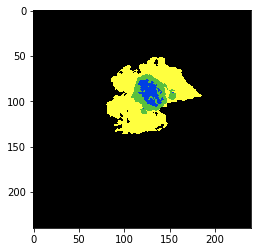

In [14]:
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
act_image = nib.load(actual_label).get_fdata()
plt.imshow(plot_labels_color(act_image[:,:,70]), cmap='gray')

---

# Model Summary

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 240, 240, 64) 2368        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 240, 240, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________